In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/mask_data'

if os.path.exists(data_dir):
    print(f"Dataset folder found at: {data_dir}")
    print("Contents:")
    print(os.listdir(data_dir))  # List all files/folders inside this folder
else:
    print(f"Dataset folder NOT found at: {data_dir}")


Dataset folder found at: /content/drive/MyDrive/Colab Notebooks/mask_data
Contents:
['No_Mask', 'Surgical', 'N95', 'N95_With_Valve', 'Cloth_Mask']


In [3]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
# 1. Load and preprocess data
def load_data(data_dir, img_size=(224,224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    print("Classes found:", class_names)

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels), class_names

In [5]:
# 2. Train-validation-test split and preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

images, labels, class_names = load_data('/content/drive/MyDrive/Colab Notebooks/mask_data')
images = preprocess_input(images)
labels_cat = to_categorical(labels, num_classes=len(class_names))

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_cat, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

Classes found: ['Cloth_Mask', 'N95', 'N95_With_Valve', 'No_Mask', 'Surgical']


In [6]:
# 3. Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
# 4. Model building and training
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=10)

for layer in base_model.layers[-30:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 770ms/step - accuracy: 0.3580 - loss: 1.4630 - val_accuracy: 0.5258 - val_loss: 1.2515
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.5276 - loss: 1.1866 - val_accuracy: 0.6065 - val_loss: 1.0512
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step - accuracy: 0.6303 - loss: 1.0080 - val_accuracy: 0.6484 - val_loss: 0.9231
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.7088 - loss: 0.8864 - val_accuracy: 0.6742 - val_loss: 0.8339
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.7228 - loss: 0.8061 - val_accuracy: 0.7290 - val_loss: 0.7624
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.7694 - loss: 0.7327 - val_accuracy: 0.7548 - val_loss: 0.7096
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.7666 - loss: 0.7000 - val_accuracy: 0.7774 - val_loss: 0.6723
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 394ms/step - accuracy: 0.7791 - loss: 0.6622 - val_accu

In [8]:
# 5. Evaluation and saving
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")
model.save('face_mask_classifier_5class.h5')

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.8515 - loss: 0.4522


Test accuracy: 86.17%


In [9]:
# 6. Predict new images
def predict_mask(image_path, model, class_names, img_size=(224,224)):
    import cv2, numpy as np
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    class_idx = np.argmax(preds)
    class_label = class_names[class_idx]
    confidence = preds[0][class_idx]
    return class_label, confidence

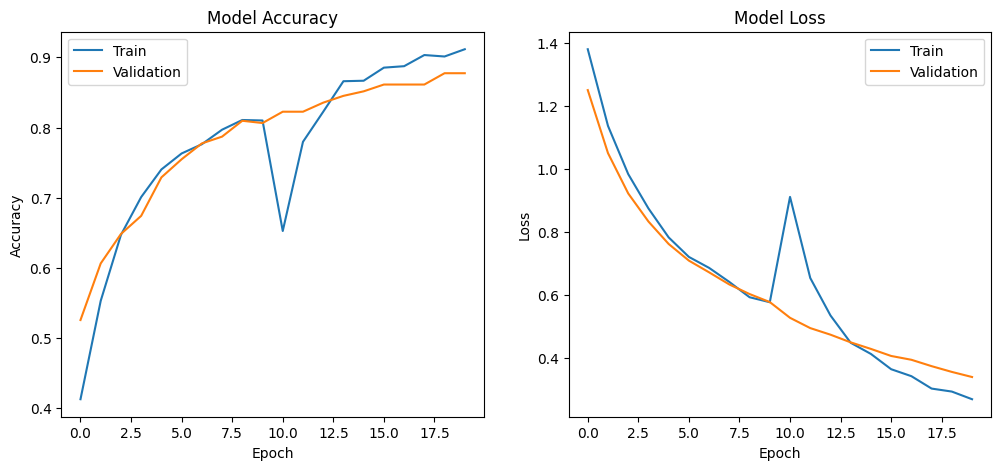

In [10]:
# 7. Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_finetune.history['loss'])
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


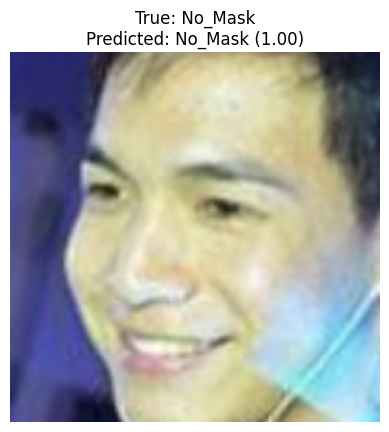

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


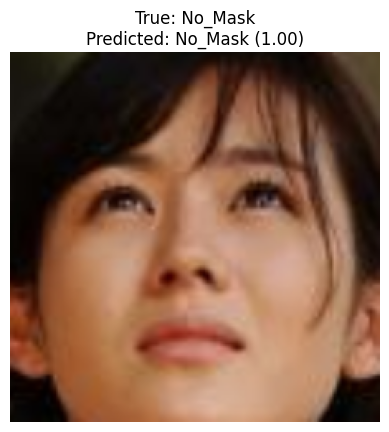

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


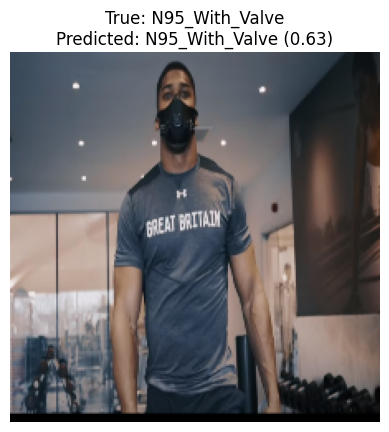

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


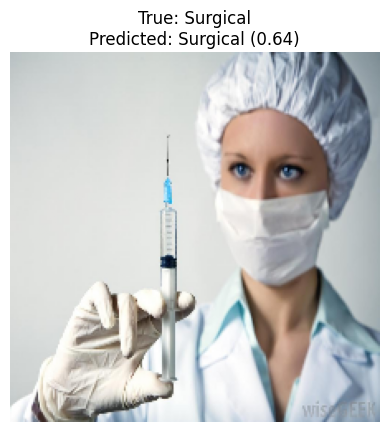

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


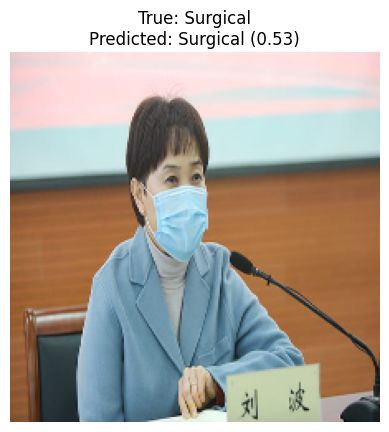

In [11]:
# 8. Predict on random test samples
import random
indices = random.sample(range(len(X_test)), 5)
for i in indices:
    img = X_test[i]
    true_label = class_names[np.argmax(y_test[i])]
    pred_probs = model.predict(np.expand_dims(img, axis=0))[0]
    pred_label = class_names[np.argmax(pred_probs)]
    confidence = np.max(pred_probs)
    plt.imshow((img + 1) / 2)
    plt.title(f"True: {true_label}\nPredicted: {pred_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step


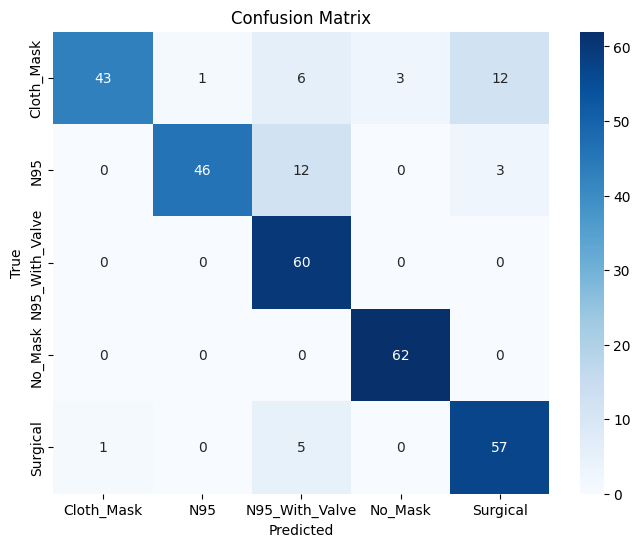

                precision    recall  f1-score   support

    Cloth_Mask       0.98      0.66      0.79        65
           N95       0.98      0.75      0.85        61
N95_With_Valve       0.72      1.00      0.84        60
       No_Mask       0.95      1.00      0.98        62
      Surgical       0.79      0.90      0.84        63

      accuracy                           0.86       311
     macro avg       0.88      0.86      0.86       311
  weighted avg       0.89      0.86      0.86       311



In [12]:
# 9. Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))